# PHYS3116 Computational Assessment: Area 51 Interns

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Introduction to assessment
**Accreted Milky Way Globular Clusters**

Using data from the Harris Catalogue of Milky Way globular clusters and vandenBerg et al. (2013), use
stellar population (metallicities [Fe/H] and ages) and dynamical information to identify potentially
accreted globular clusters. Consider if there are some globular clusters that stand out in the agemetallicity relation or that do not rotate with the bulk of other globular clusters.

Consider what the above findings might mean for how the Milky Way formed and how many of its
globular clusters could be accreted and how many may have formed within the Milky Way. Consider
what further tests could be performed to delineate various possible formation scenarios.

Reformatted .csv versions of relevant data tables have been uploaded to Moodle for convenience.

## Introduction to this file
This file investigates potential accreted globular clusters through co-rotation the clusters

We can observe pattern of rotation through the following:
1. Remove co-rotation of the sun from the LSR velocity to observe rotation direction
2. Graph non-co-rotation velocity in respect to $l$ to observe co-rotation of the bulk of the clusters

We should observe a sinusoidal graph for the velocity to $l$ graph if it is co-rotating, where accreted clusters should be out of phase. 

We can get disparity of rotation to co-rotation curves
1. We can obtain predicted LSR velocity we should observe from a formula and apply it to what we have
2. For each cluster, we compare projected and actual LSR Velocity and we determine amount of co-rotation through it and see its deviations

We should have clusters be close to predicted corotation speed, or otherwise they should have similar deviations if they are co-rotating, accreted clusters should be out of this bulk that we should observe

## 0) Merging CSV files

In [50]:
harris1 = pd.read_csv('HarrisPartI.csv')
harris3 = pd.read_csv('HarrisPartIII.csv')
merge = pd.merge(harris1, harris3, on='ID', how='outer')
merge.head()

,ID,Name,RA,DEC,L,B,R_Sun,R_gc,X,Y,...,v_LSR,sig_v,sig_v_e,c,r_c,r_h,mu_V,rho_0,lg_tc,lg_th
0,1636-283,ESO452-SC11,16:39:25.45,-28:23:55.3,351.91,12.10,8.3,2.1,8.0,-1.1,...,NaN,NaN,NaN,1.00,0.50,0.50,20.75,2.50,8.07,7.87
1,2MS-GC01,2MASS-GC01,18:08:21.81,-19:49:47,10.48,0.11,3.6,4.5,3.5,0.7,...,NaN,NaN,NaN,0.85,0.85,1.65,NaN,NaN,NaN,8.43
2,2MS-GC02,2MASS-GC02,18:09:36.50,-20:46:44,9.79,-0.61,4.9,3.2,4.9,0.8,...,-227.4,NaN,NaN,0.95,0.55,0.55,NaN,NaN,NaN,7.72
3,AM 1,E 1,03:55:02.3,-49:36:55,258.34,-48.47,123.3,124.6,-16.5,-80.1,...,101.3,NaN,NaN,1.36,0.17,0.41,23.62,0.03,8.96,9.61
4,AM 4,NaN,13:56:21.7,-27:10:03,320.28,33.51,32.2,27.8,20.7,-17.2,...,NaN,NaN,NaN,0.70,0.41,0.43,24.75,-0.05,8.42,8.32


## 1) Extracting data from .csv files


The data columns we need are:
- l and b for positions and projections
- $v_{lsr}$, as it is 'Radial velocity relative to Solar neighborhood LSR', so we dont need to take in account the sun's deviations in movement. So we use this instead of $v_r$
- Additionally we will remove data that has NA for $v_{LSR}$ as we are unable to use such data for our purposes
- We need $R_{Sun}$ as well

In [51]:
# We choose right columns that we care about
rotation_data = merge[['ID', 'L', 'B', 'v_LSR', 'R_Sun']]

# Get rid of rows we dont care about, because we lack the v_LSR for them, so we cant find co-rotation for it
rotation_data = rotation_data.dropna(subset=['v_LSR'])
rotation_data.head()


,ID,L,B,v_LSR,R_Sun
2,2MS-GC02,9.79,-0.61,-227.4,4.9
3,AM 1,258.34,-48.47,101.3,123.3
5,Arp 2,8.55,-20.79,122.4,28.6
8,Djorg 1,356.69,-2.47,-355.0,13.7
12,Eridanus,218.10,-41.33,-39.1,90.1


## 2) Removing Corotation of Milky Way
Now we convert $v_{LSR}$ to the no-corotation of $v_{NC}$. This is done by the following formula:

$v_{NC} = v_{LSR} + V_{sun}\cdot \hat r = v_{LSR} + V_{0}sin(l)cos(b)$

where $\hat r$ is the unit vector from the sun to the cluster and $V_{sun}$ as the vector of sun circular motion with $V_{0}$ = 230 km/s

All velocities adds the sun's velocity to that vector component.

This gives us the LOS velocity of the cluster from the sun but with the galaxy center as the velocity of reference. This allows us to determine the true direction of movement of clusters irrespective of the sun's movement.

Now we append this to the data:

In [52]:
V_0 = 238
l = np.radians(rotation_data['L'])
b = np.radians(rotation_data['B'])
rotation_data['v_NC'] = (
    rotation_data['v_LSR'] +
    V_0*np.sin(l)*np.cos(b)
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_NC
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-186.933366
3,AM 1,258.34,-48.47,101.3,123.3,-53.240608
5,Arp 2,8.55,-20.79,122.4,28.6,155.480101
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.728941
12,Eridanus,218.10,-41.33,-39.1,90.1,-149.375783


## 3) Graphing l and v_NC

We can graph $l$ and $v_{NC}$ to see the position of the clusters and observe their direction of travel and we can relatively see which parts are rotating in the same direction or not

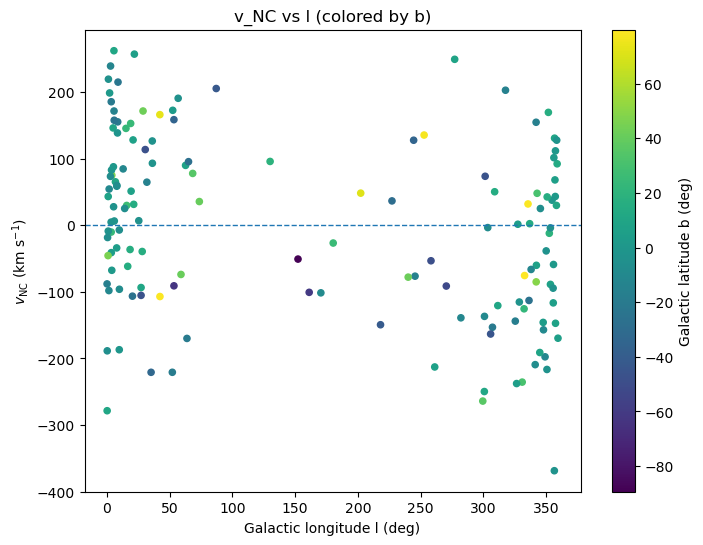

In [53]:
plt.figure(figsize=(8,6))
scatt = plt.scatter(rotation_data['L'], rotation_data['v_NC'], c=rotation_data['B'], s=20)
plt.xlabel('Galactic longitude l (deg)')
plt.ylabel(r'$v_{\rm NC}$ (km s$^{-1}$)')
plt.axhline(0, linestyle='--', linewidth=1)
cbar = plt.colorbar(scatt); cbar.set_label(r'Galactic latitude b (deg)')
plt.title('v_NC vs l (colored by b)')
plt.show()

Adding an LSR velocity graph as comparison

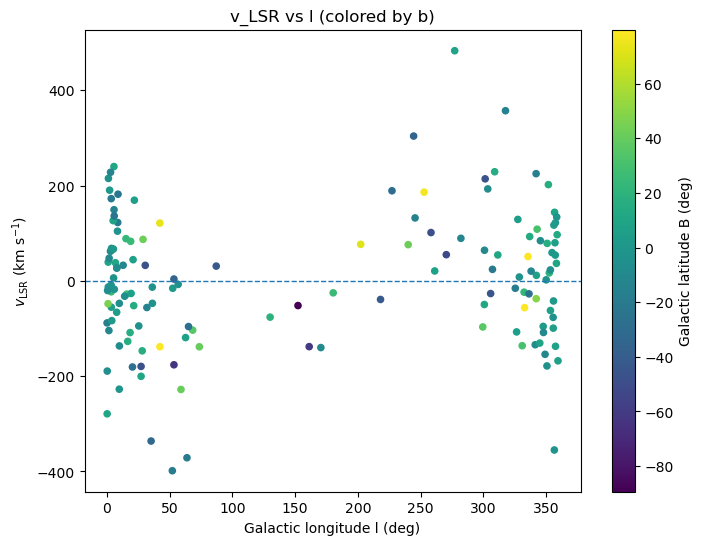

In [54]:
plt.figure(figsize=(8,6))
sc = plt.scatter(rotation_data['L'], rotation_data['v_LSR'], c=rotation_data['B'], s=20)
plt.xlabel('Galactic longitude l (deg)')
plt.ylabel(r'$v_{\rm LSR}$ (km s$^{-1}$)')
plt.axhline(0, linestyle='--', linewidth=1)
cbar = plt.colorbar(sc); cbar.set_label(r'Galactic latitude B (deg)')
plt.title('v_LSR vs l (colored by b)')
plt.show()

We do not see a clear pattern of rotation from these graph, for corotation, we should observe a sort of sinusoidal graph where at 90 degrees we have positive values and at 270 degrees we have negative values, but we observe a scattered graph without much patterns. This indicates that it might have much of a co-rotation and dispersion of velocity amongst the clusters are high.

## 3) Obtain Galactrocentric cylindrical radius

To obtain our predicted NC velocity, we require the top down radius and the following formula obtains this:

$R = \sqrt{R_{0}^2 + (R_{sun}cos(b))^2-2R_0R_{sun}cos(b)cos(l)}$

Where $R_{0} = 8.2kpc$, the distance between galactic center and the sun and $R_{sun}$ being the distance between galactic center and the sun.

The formula comes from the cosine rule with a triangle with corners of sun center, galactic center, and the in plane position of the cluster. The sides being $R_{sun}cos(b)$, $R_{0}$ and $R$ with angle $l$ opposite $R$.


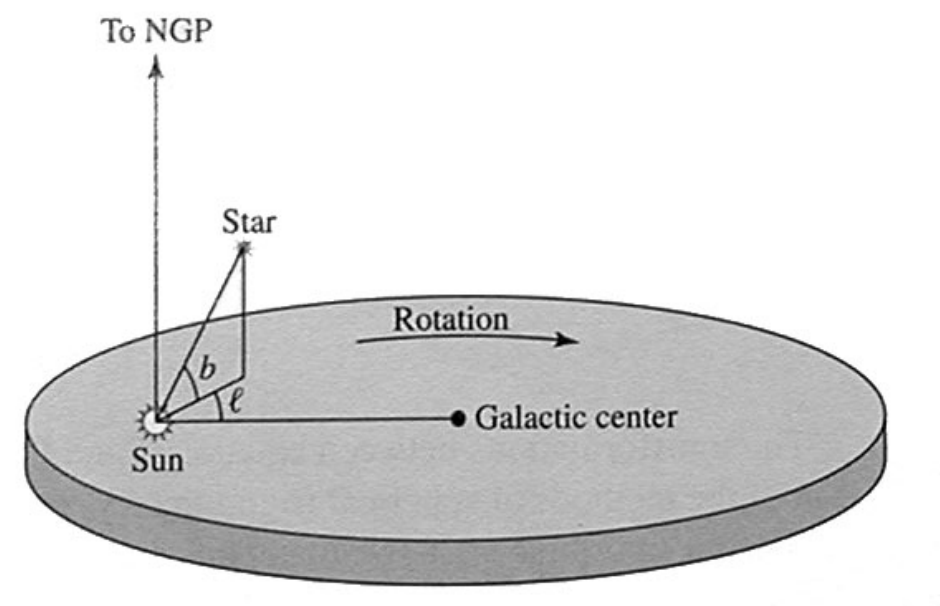



In [55]:
R0 = 8.2
rotation_data['R'] = (
  np.sqrt(
    R0**2 + 
    (rotation_data['R_Sun']*np.cos(b))**2 - 
    2 * R0 * rotation_data['R_Sun'] * np.cos(b) * np.cos(l)
  )
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_NC,R
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-186.933366,3.473039
3,AM 1,258.34,-48.47,101.3,123.3,-53.240608,83.792372
5,Arp 2,8.55,-20.79,122.4,28.6,155.480101,18.668765
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.728941,5.521288
12,Eridanus,218.10,-41.33,-39.1,90.1,-149.375783,74.283137


## 4) Obtain modelled LSR Velocity
Orbital speed is generally constant with radius possibly due to dark matter:

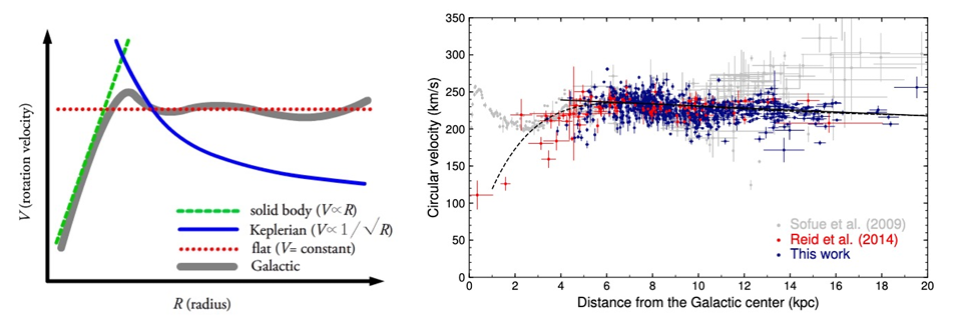

Distance from the sun to the galactic center: $R_0 = 8kpc$

Circular Velocity of Local Standrd of Rest at Sun $V_0 = 200km/s$

$V_c(R) = 230km/s$

We can obtain the modelled Velocity with the following formula:

$V_{pred} = (\frac{R_0}{R}V - V_0)sin(l)$

Where  V is its circular orbital rotation velocity

In [56]:
V_c = 230
rotation_data['v_pred'] = (
  ((R0/rotation_data['R']) * V_c - V_0) * 
  np.sin(l) * 
  np.cos(b)
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_NC,R,v_pred
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-186.933366,3.473039,51.865339
3,AM 1,258.34,-48.47,101.3,123.3,-53.240608,83.792372,139.925472
5,Arp 2,8.55,-20.79,122.4,28.6,155.480101,18.668765,-19.038521
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.728941,5.521288,-5.975375
12,Eridanus,218.10,-41.33,-39.1,90.1,-149.375783,74.283137,98.511793


## 5) Residuals and Co-Rotation test
We find the residuals and flag non-corotators:

$\Delta v = v_{NC} - v_{model}^{NC}$

This value 

In [57]:
rotation_data['v_delta'] = rotation_data['v_LSR'] - rotation_data['v_pred']
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_NC,R,v_pred,v_delta
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-186.933366,3.473039,51.865339,-279.265339
3,AM 1,258.34,-48.47,101.3,123.3,-53.240608,83.792372,139.925472,-38.625472
5,Arp 2,8.55,-20.79,122.4,28.6,155.480101,18.668765,-19.038521,141.438521
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.728941,5.521288,-5.975375,-349.024625
12,Eridanus,218.10,-41.33,-39.1,90.1,-149.375783,74.283137,98.511793,-137.611793


Additionally as we are using line of sight velocity, perpendicular movement to the radius would have a lower signal, thus we remove them as the data is unreliable.

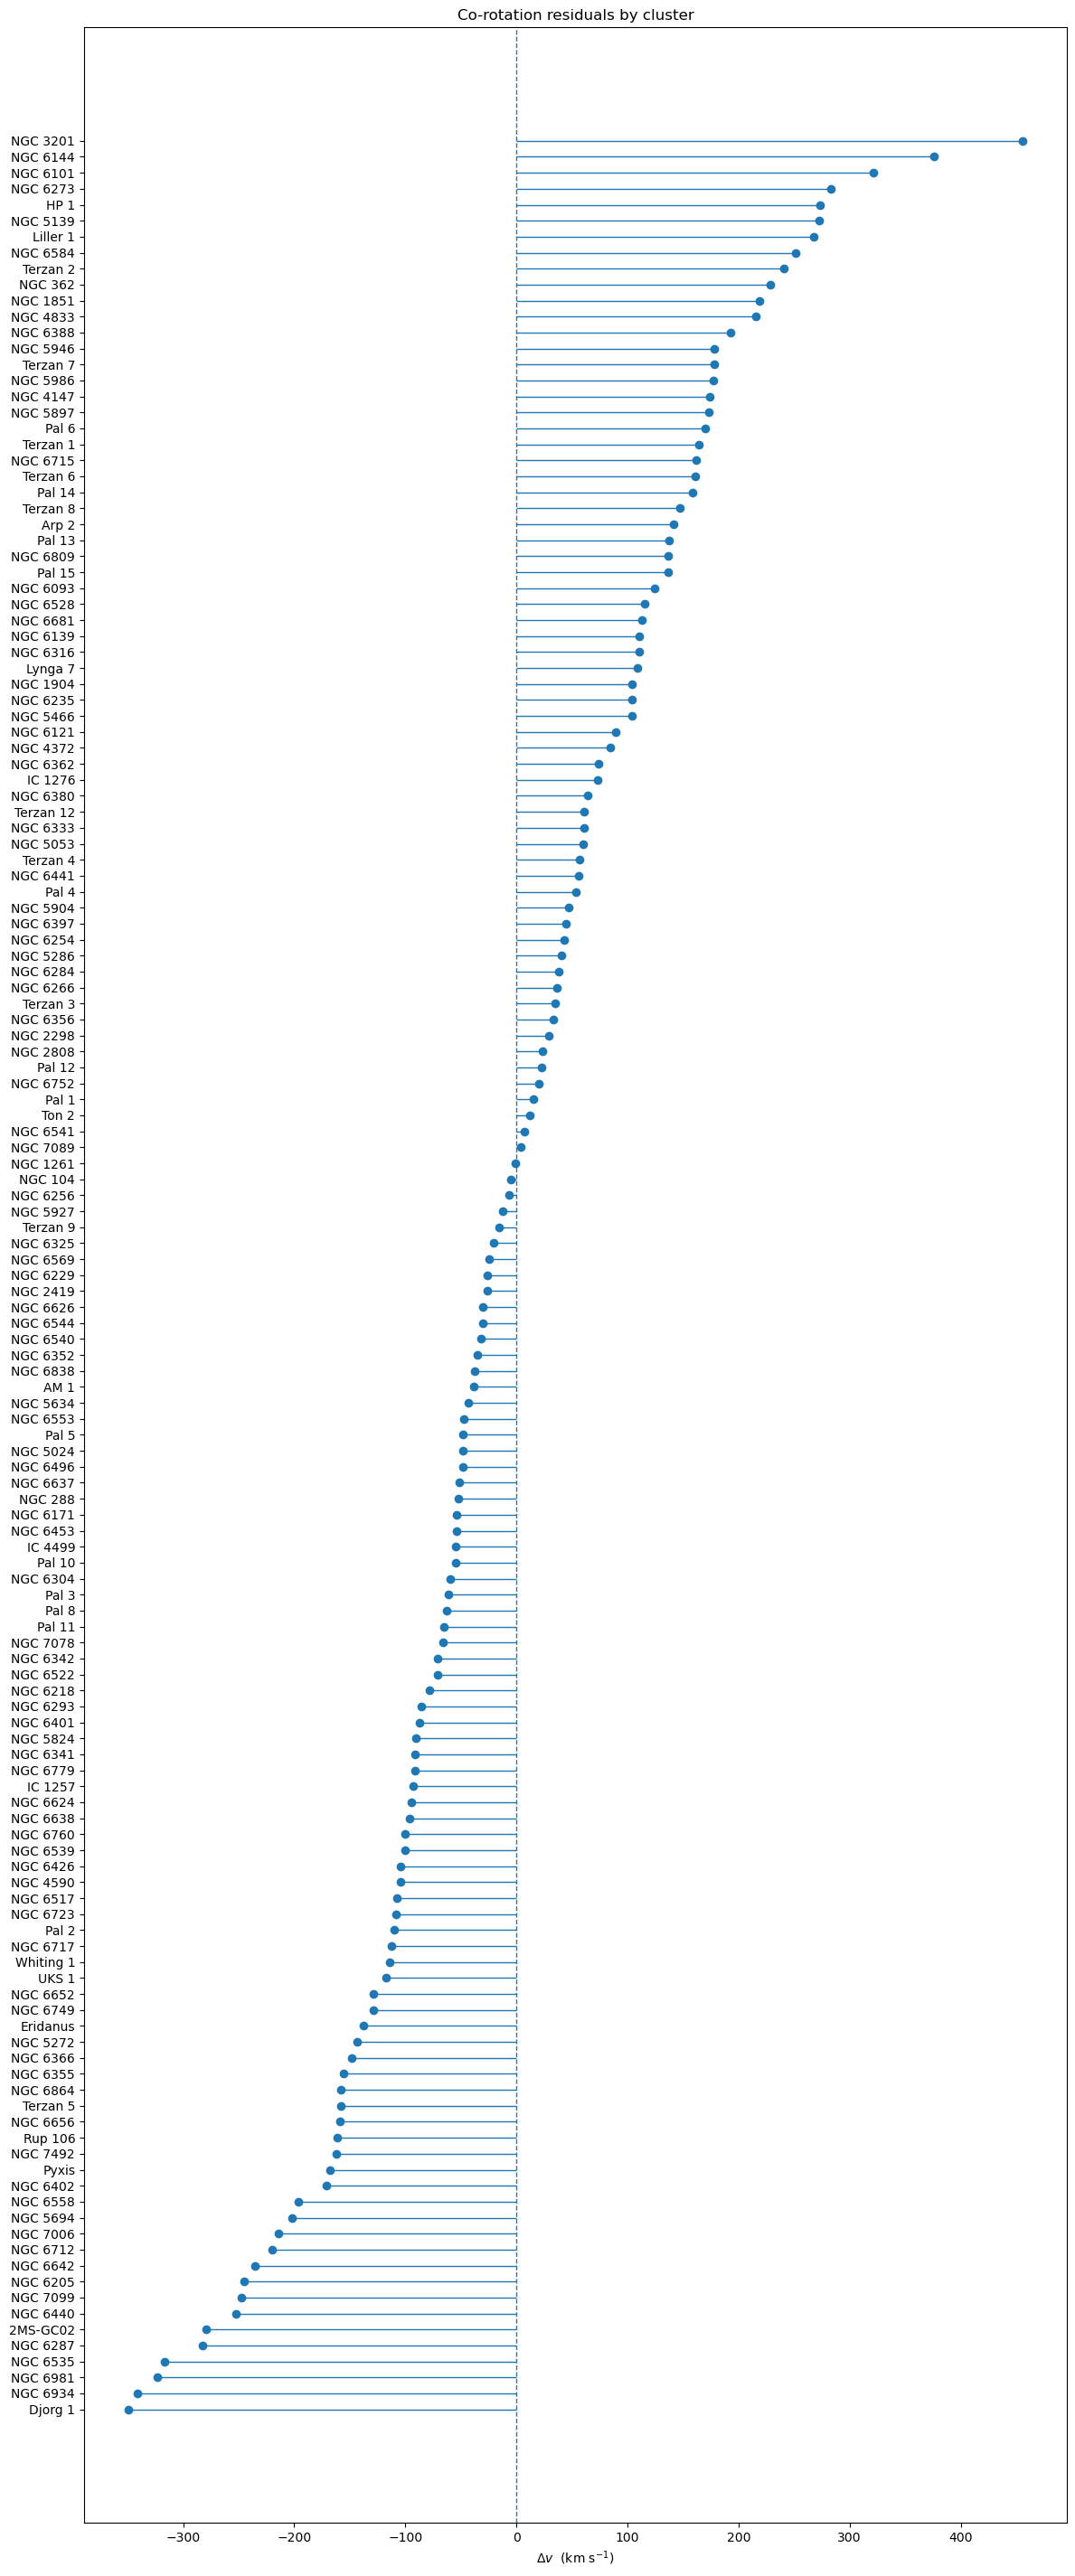

In [58]:
results = rotation_data[['ID', 'v_delta']].dropna().sort_values('v_delta')
results = results.sort_values('v_delta')                       

y = np.arange(len(results))
fig, ax = plt.subplots(figsize=(12, max(4, len(results)*0.2)))

# lollipop display things
ax.hlines(y, 0, results['v_delta'], linewidth=1)
ax.plot(results['v_delta'], y, 'o')

# zero line in the middle
ax.axvline(0, linestyle='--', linewidth=1)

# The id labels
ax.set_yticks(y)
ax.set_yticklabels(results['ID'])

ax.set_xlabel(r'$\Delta v$  (km s$^{-1}$)')

ax.set_title('Co-rotation residuals by cluster')
plt.tight_layout()
plt.show()


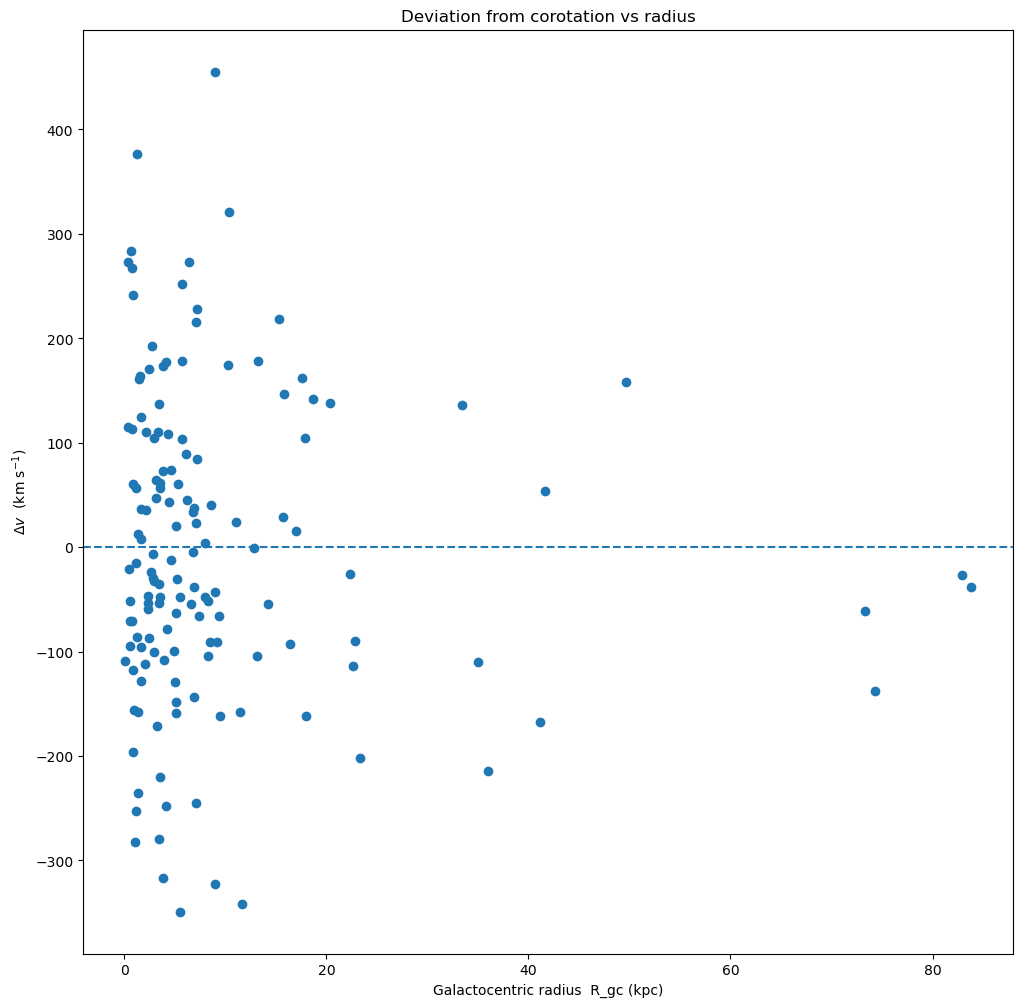

In [59]:
plt.figure(figsize=(12,12))
plt.axhline(0, ls='--')

plt.scatter(rotation_data['R'], rotation_data['v_delta'])
plt.xlabel('Galactocentric radius  R_gc (kpc)')
plt.ylabel(r'$\Delta v$  (km s$^{-1}$)')
plt.title('Deviation from corotation vs radius')
plt.show()

With the graphs we obtained, it appears that there is no consensus of co-rotation as the effects are very spread out. We expected most of the globulars to be around the mean velocity for rotation with accreted being the outliers however the data shows implies otherwise. A reason could be that the mean rotation speed of Milky Way globular clusters is too small to have a consensus corotation for us to use, and thus we are unable to accurately use co-rotation to determine accreted globular systems.

## Research progress

https://ui.adsabs.harvard.edu/search/fq=%7B!type%3Daqp%20v%3D%24fq_database%7D&fq_database=(database%3Aastronomy%20OR%20database%3Aphysics)&q=corotation%20globular%20cluster&sort=date%20desc%2C%20bibcode%20desc&p_=0

https://iopscience.iop.org/article/10.1088/1674-4527/20/8/130/pdf < things i wanted, relating degree to velocity

https://iopscience.iop.org/article/10.3847/2041-8213/aaf73f/pdf < for rotations


Gave up on using papers because i could not find anything, most of them used 6D Kinematics

https://ned.ipac.caltech.edu/level5/Sept16/Sofue/Sofue2.html